In [ ]:
!pip3 install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.8 MB/s eta 0:00:00


In [ ]:
## 라이브러리 import

import gymnasium as gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
learning_rate = 0.001
gamma = 0.98
buffer_limit = 50000
batch_size = 64

In [ ]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

In [ ]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else :
            return out.argmax().item()

In [ ]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def main_2():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    best_score = -float('inf')
    print_interval = 10                # q_target 업데이트 주기를 10으로 변경
    score = 0.0
    avg_scores_2 = []
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.001, 0.08 - 0.01*(n_epi/200)) # 엡실론 값을 0.001로 낮춤
        s, _ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, truncated, info = env.step(a)
            done_mask = 0.0 if (done or truncated) else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if (done or truncated):
                break

        if memory.size()>2000:   ## 버퍼에 2000개 이상의 transition이 쌓이면 학습 시작
            train(q, q_target, memory, optimizer)

        if score >= best_score:
            best_score = score
            torch.save(q.state_dict(), f"dqn_cartpole{n_epi}_.pth")
            print(f"New best score: {best_score}. Model saved.")

        if n_epi%print_interval==0 and n_epi!=0:
            avg_score = score / print_interval
            avg_scores_2.append(avg_score)  # 평균 점수 저장
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0


    env.close()
    plt.plot(avg_scores_2)
    plt.xlabel('Episodes (x20)')
    plt.ylabel('Average Score')
    plt.title('Average Score vs Episodes')
    plt.show()

New best score: 9.0. Model saved.
New best score: 19.0. Model saved.
New best score: 28.0. Model saved.
New best score: 39.0. Model saved.
New best score: 48.0. Model saved.
New best score: 57.0. Model saved.
New best score: 67.0. Model saved.
New best score: 76.0. Model saved.
New best score: 86.0. Model saved.
New best score: 95.0. Model saved.
New best score: 106.0. Model saved.
n_episode :10, score : 10.6, n_buffer : 106, eps : 8.0%
n_episode :20, score : 9.7, n_buffer : 203, eps : 7.9%
n_episode :30, score : 9.2, n_buffer : 295, eps : 7.8%
n_episode :40, score : 9.3, n_buffer : 388, eps : 7.8%
n_episode :50, score : 8.9, n_buffer : 477, eps : 7.8%
n_episode :60, score : 9.9, n_buffer : 576, eps : 7.7%
n_episode :70, score : 10.4, n_buffer : 680, eps : 7.6%
n_episode :80, score : 9.9, n_buffer : 779, eps : 7.6%
n_episode :90, score : 9.6, n_buffer : 875, eps : 7.5%
n_episode :100, score : 9.7, n_buffer : 972, eps : 7.5%
n_episode :110, score : 9.4, n_buffer : 1066, eps : 7.4%
n_epi

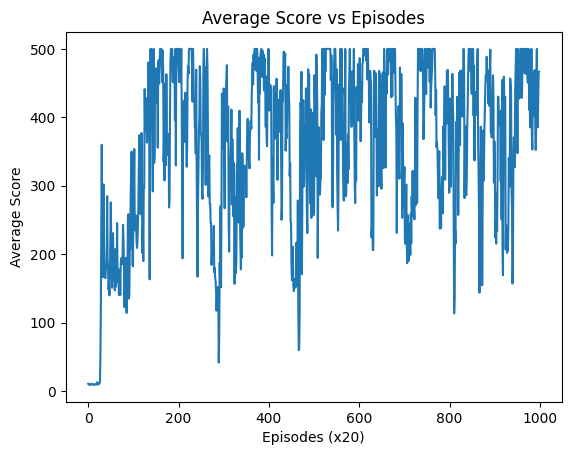

In [ ]:
main_2()